In [1]:
import tensorflow as tf
import keras
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
import librosa 
audio_path = 'reggae.00000.wav' 
x , sr = librosa.load(audio_path)
librosa.load(audio_path, sr=44100)

(array([ 0.01008807,  0.00913067,  0.00802994, ..., -0.04625891,
        -0.03492948, -0.01661832], dtype=float32), 44100)

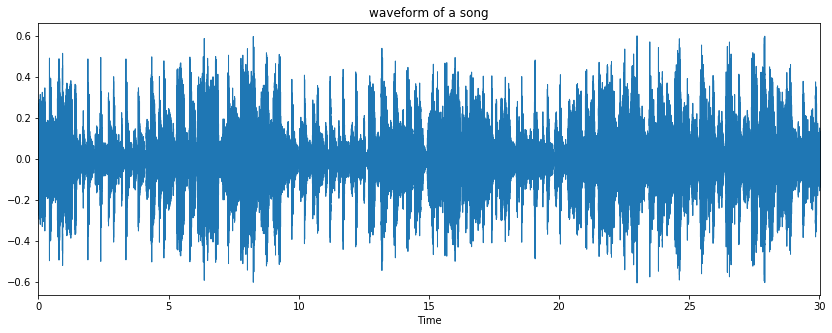

In [3]:

import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
plt.title('waveform of a song')
librosa.display.waveplot(x, sr=sr)


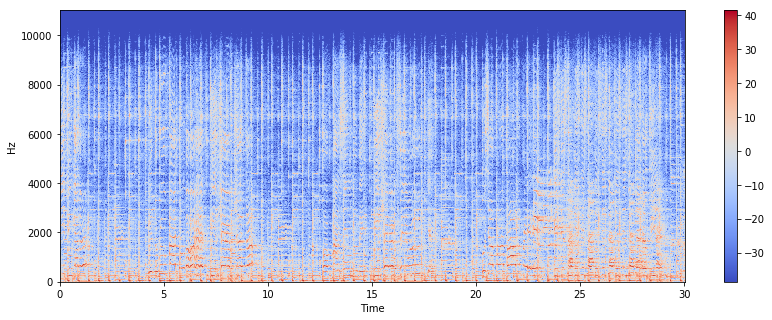

In [4]:

X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

In [5]:

import tarfile 
myfile = tarfile.open('genres.tar.gz')

myfile.extractall()
cmap = plt.get_cmap('inferno')

plt.figure(figsize=(10,10))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)     
    for filename in os.listdir(f'./genres/{g}'):
        songname = f'./genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

<Figure size 720x720 with 0 Axes>

In [6]:

header = 'filename rmse chroma_stft spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [7]:
# creating csv file, storing features 
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'./genres/{g}'):
        songname = f'./genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        rmse = librosa.feature.rmse(y=y) 
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(rmse)} {np.mean(chroma_stft)}  {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [7]:

# reading csv file 
data = pd.read_csv('data.csv')

data.shape
# drop filename 
data = data.drop(['filename'],axis=1)
data.shape
data.head()

,rmse,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.130225,0.349943,1784.420446,2002.650192,3806.485316,0.083066,-113.596742,121.557302,-19.158825,42.351029,...,8.810668,-3.667367,5.751690,-5.162761,0.750947,-1.691937,-0.409954,-2.300208,1.219928,blues
1,0.095918,0.340983,1529.835316,2038.617579,3548.820207,0.056044,-207.556796,124.006717,8.930562,35.874684,...,5.376802,-2.239119,4.216963,-6.012273,0.936109,-0.716537,0.293875,-0.287431,0.531573,blues
2,0.175573,0.363603,1552.481958,1747.165985,3040.514948,0.076301,-90.754394,140.459907,-29.109965,31.689014,...,5.789265,-8.905224,-1.083720,-9.218359,2.455805,-7.726901,-1.815724,-3.433434,-2.226821,blues
3,0.141191,0.404779,1070.119953,1596.333948,2185.028454,0.033309,-199.431144,150.099218,5.647594,26.871927,...,6.087676,-2.476420,-1.073890,-2.874777,0.780976,-3.316932,0.637981,-0.619690,-3.408233,blues
4,0.091563,0.308590,1835.494603,1748.362448,3580.945013,0.101500,-160.266031,126.198800,-35.605448,22.153301,...,-2.806385,-6.934122,-7.558619,-9.173552,-4.512166,-5.453538,-0.924162,-4.409333,-11.703781,blues


In [8]:
genre_list = data.iloc[:, -1] # creating a list and indexing it 
# print(genre_list)
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))
# print(y)
print(len(y))
print(X.shape)

1000
(1000, 26)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [10]:
from sklearn import svm

# Create a classifier: a support vector classifier
# svc = svm.SVC(probability=False,  kernel="rbf", C=2.8, gamma=.0073,verbose=10)
svc = svm.SVC(probability=False,  kernel="linear", C=2.8, gamma=.0073,verbose=10)

In [11]:
svc.fit(X_train,y_train)

[LibSVM]

SVC(C=2.8, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0073, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=10)

In [12]:
yhat_ts = svc.predict(X_test)

In [13]:
acc = np.mean(yhat_ts == y_test)
print('Accuaracy = {0:f}'.format(acc))

Accuaracy = 0.660000


In [14]:
np.max(y_train)

9

In [15]:
X_train.shape

(750, 26)

In [16]:
nin=X_train.shape[1]

In [17]:
nin 

26

In [18]:

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import regularizers

In [19]:
import tensorflow
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout,Dense

In [45]:
nh = 150 # number of hidden units
nout = int(np.max(y_train)+1)    # number of outputs = 10 since there are 10 classes
model = Sequential()
model.add(Dense(units=nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(units=nout, activation='softmax', name='output'))

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 150)               4050      
_________________________________________________________________
output (Dense)               (None, 10)                1510      
Total params: 5,560
Trainable params: 5,560
Non-trainable params: 0
_________________________________________________________________


In [47]:
from tensorflow.keras import optimizers

opt = optimizers.Adam(lr=0.01) # beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [48]:
hist = model.fit(X_train, y_train, epochs=30, batch_size=100, validation_data=(X_test,y_test))

Train on 750 samples, validate on 250 samples
Epoch 1/30
750/750 [==============================] - 0s 517us/step - loss: 2.1664 - acc: 0.2107 - val_loss: 1.8635 - val_acc: 0.3440
Epoch 2/30
750/750 [==============================] - 0s 17us/step - loss: 1.6281 - acc: 0.4120 - val_loss: 1.6066 - val_acc: 0.4360
Epoch 3/30
750/750 [==============================] - 0s 20us/step - loss: 1.4598 - acc: 0.4667 - val_loss: 1.5726 - val_acc: 0.4280
Epoch 4/30
750/750 [==============================] - 0s 21us/step - loss: 1.3552 - acc: 0.5333 - val_loss: 1.4418 - val_acc: 0.4800
Epoch 5/30
750/750 [==============================] - 0s 21us/step - loss: 1.2790 - acc: 0.5333 - val_loss: 1.4074 - val_acc: 0.5080
Epoch 6/30
750/750 [==============================] - 0s 21us/step - loss: 1.2132 - acc: 0.5880 - val_loss: 1.3416 - val_acc: 0.5240
Epoch 7/30
750/750 [==============================] - 0s 21us/step - loss: 1.1725 - acc: 0.5920 - val_loss: 1.3387 - val_acc: 0.5720
Epoch 8/30
750/750 [==

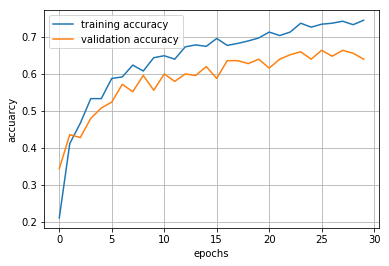

In [49]:
tr_accuracy = hist.history['acc']
val_accuracy = hist.history['val_acc']

plt.plot(tr_accuracy)
plt.plot(val_accuracy)
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.legend(['training accuracy', 'validation accuracy'])

In [101]:

# from keras import backend as K
import tensorflow
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout,Dense
K.clear_session() 

model = Sequential()
model.add(Dense(200, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(10, activation='softmax'))

model.summary()

print(X_train.shape[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               5400      
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               25728     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 40,034
Trainable params: 40,034
Non-trainable params: 0
_________________________________________________________________
26


In [16]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=0.01)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
history = model.fit(X_train, y_train, epochs=100, verbose=0,batch_size=128,
                   validation_data=(X_test,y_test))

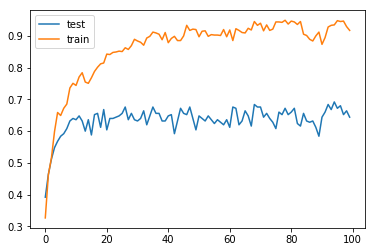

In [18]:
plt.plot(history.history['val_acc'])
plt.plot(history.history['acc'])
plt.legend(['test', 'train'])

In [19]:
test_loss, test_acc = model.evaluate(X_test,y_test)

250/250 [==============================] - 0s 36us/step


In [20]:
print(test_acc*100,'%')

64.40000019073486 %
